# **Task 3**
# 3.1: Implement the CBIR system using Color Moments (mean, standard deviation, and skewness) as an image representation. Use Euclidean as distant measure and assign equal weights to each moment. Compute precision, recall, F1 score, and time. Calculate the Area Under the Curve (AUC) to measure the overall performance across different threshold settings. Note that you need to compute these measures as an average of at least 10 different quires.
# 3.2: Same as task 3.1 but with different weights. You need to give a weigh relative to the important of the moment.
## 3.3: Same as task 3.2 but with the addition of more Moments including Median, Mode, and Kurtosis.



The same function in task 1 is used here for loading images.

In [ ]:
from datasets import load_dataset
from base64 import b64decode
from PIL import Image
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from scipy.spatial.distance import euclidean
from scipy.stats import moment

import matplotlib.pyplot as plt
import cv2
import numpy as np
import time


def process_fn(sample):
    image_bytes = b64decode(sample['image_bytes'])
    image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)
    return image

dataset_dict = load_dataset('json', data_files='images_set.json')
data = dataset_dict['train']

images = np.array([process_fn(sample) for sample in data], dtype="object")

Task 3 involves the implementation of a Content-Based Image Retrieval (CBIR) system utilizing Color Moments as a distinctive representation for images. The ‘calculate_color_moments’ function is essential in this task, computing mean, standard deviation, and skewness for each color channel (RGB) in an image. The process involves calculating histograms, normalizing them for probability distribution, and determining the specified moments. These calculated moments, representing aspects of color distribution, are then concatenated into a feature vector. The flexibility to assign weights to each moment allows us to control the emphasis on different characteristics in the color distribution.


In [ ]:
def calculate_color_moments(image, num_bins=256, moment_weights=[1, 1, 1]):
    moments = []

    for i in range(3):
        channel = image[:, :, i]

        # Calculate histogram
        hist = cv2.calcHist([channel], [0], None, [num_bins], [0, 256])
        hist = hist.flatten()

        # # Normalize the histogram to ensure it represents a probability distribution
        hist /= np.sum(hist)

        # Calculate moments
        mean = np.sum(hist * np.arange(num_bins)) / np.sum(hist)
        std_dev = np.sqrt(np.sum(hist * (np.arange(num_bins) - mean)**2) / np.sum(hist))
        skewness = np.sum(hist * ((np.arange(num_bins) - mean) / std_dev)**3) / np.sum(hist)

        # Apply moment weights
        weighted_moments = [mean, std_dev, skewness] * np.array(moment_weights)

        moments.extend(weighted_moments)

    return moments


The function ‘calculate_color_moments_with_extended_stats’ extracts color moments with additional statistical features from an image. These features include mean, standard deviation, skewness, median, mode, and kurtosis. The function allows customization through the ‘moment_weights’ parameter, enabling adjustments to the weights assigned to each moment. This flexibility in adjusting weights provides the opportunity to observe the impact of different statistical contributions on the overall performance of the CBIR system. We can experiment by tuning the weights to observe variations in the system's effectiveness and determine the most influential moments for our specific use case.

In [ ]:
def calculate_color_moments_with_extended_stats(image, num_bins=256, moment_weights=[1, 1, 1, 1, 1, 1]):
    moments = []

    for i in range(3):
        channel = image[:, :, i]

        # Calculate histogram
        hist = cv2.calcHist([channel], [0], None, [num_bins], [0, 256])
        hist = hist.flatten() / np.sum(hist)

        # # Normalize the histogram to ensure it represents a probability distribution
        hist /= np.sum(hist)

        # Calculate moments
        mean = np.sum(hist * np.arange(num_bins)) / np.sum(hist)
        std_dev = np.sqrt(np.sum(hist * (np.arange(num_bins) - mean)**2) / np.sum(hist))
        skewness = np.sum(hist * ((np.arange(num_bins) - mean) / std_dev)**3) / np.sum(hist)

        median = np.median(channel) / np.sum(hist)
        mode_value = float(np.argmax(hist)) / np.sum(hist)
        kurtosis = np.sum(hist * ((np.arange(num_bins) - mean) / std_dev)**4) / np.sum(hist) - 3

        # Apply moment weights
        weighted_moments = [mean, std_dev, skewness, median, mode_value, kurtosis] * np.array(moment_weights)

        moments.extend(weighted_moments)

    return moments

The ‘calculate_similarity’ function, employed in Task 3, is the same function used in Task 2. It facilitates the measurement of similarity between the features of a query image and a collection of images in a database. Employing the Euclidean distance as a distance metric, this function compares the query features to the features of each image in the database. Consequently, it calculates the Euclidean distance for each pair of feature vectors, providing a quantitative measure of dissimilarity. Lower Euclidean distances denote higher similarity, signifying that images with similar color moments are closer in feature space. The resulting list of distances signifies the dissimilarity between the query image and each image in the database.

In [ ]:
def calculate_similarity(query_features, database_features):
    distances = [euclidean(query_features, features) for features in database_features]
    return distances


The ‘cbir_using_moments’ function is utilized to perform Content-Based Image Retrieval (CBIR) with color moments as image representations. This function takes a query image, a database image collection (I call it images), and additional parameters such as the number of top results to retrieve (‘top_k’), visualization preferences (‘visu’), and moment weights. The ‘func’ parameter provides flexibility, allowing the selection of a moment calculation function, either ‘calculate_color_moments’ or ‘calculate_color_moments_with_extended_stats’, with ‘calculate_color_moments’ set as the default.
The function calculates the color moments for both the query image and the database images, utilizing the specified moment calculation function. It then measures the similarity between the query image and each database image using the Euclidean distance. The results are ranked based on similarity, and the top-k images are displayed along with their distances and, if applicable, channel-specific weighted moments.



Query Image:
Distance: 0.0

For channel R:
Weighted Moments: [95.00933804229135, 83.43261762425914, 0.3702757181452361]

For channel G:
Weighted Moments: [52.749277843276104, 61.58745633724671, 1.2739375622392948]

For channel B:
Weighted Moments: [51.83636485458828, 57.98441507983839, 1.316950951827229]


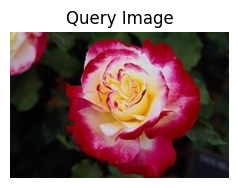

Rank 1:
Distance: 0.0

For channel R:
Weighted Moments: [95.00933804229135, 83.43261762425914, 0.3702757181452361]

For channel G:
Weighted Moments: [52.749277843276104, 61.58745633724671, 1.2739375622392948]

For channel B:
Weighted Moments: [51.83636485458828, 57.98441507983839, 1.316950951827229]


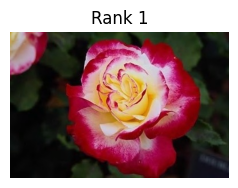

Rank 2:
Distance: 13.020523942271284

For channel R:
Weighted Moments: [97.48427321857889, 73.37403026831377, 0.20897411748632122]

For channel G:
Weighted Moments: [56.14083863527958, 65.14294908442733, 1.0378429341709767]

For channel B:
Weighted Moments: [45.976562531955096, 59.89960158563576, 1.3655846236774871]


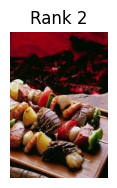

Rank 3:
Distance: 13.22695696808805

For channel R:
Weighted Moments: [93.99833179236157, 82.0240330393152, 0.38804204104568774]

For channel G:
Weighted Moments: [61.52221679333434, 62.11581803599364, 0.9440273036359408]

For channel B:
Weighted Moments: [44.569223995760694, 51.52154220111991, 1.4322940473518573]


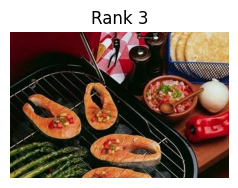

Rank 4:
Distance: 13.477731903897554

For channel R:
Weighted Moments: [89.21729545313792, 86.97301371821777, 0.4244498289466313]

For channel G:
Weighted Moments: [60.20586150471445, 55.47114031335778, 0.5500301321422]

For channel B:
Weighted Moments: [53.39906830866221, 51.723840809172835, 0.6897948890976038]


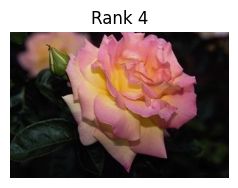

Rank 5:
Distance: 13.711317084417658

For channel R:
Weighted Moments: [92.59888699483417, 74.56145096625245, 0.3743356104186032]

For channel G:
Weighted Moments: [58.58912151448567, 61.63872478116833, 1.1772046754152379]

For channel B:
Weighted Moments: [47.181277205170026, 51.08274903356708, 1.5884883037310167]


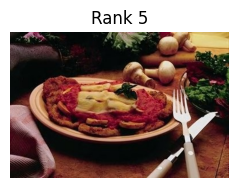

Rank 6:
Distance: 16.520550647643343

For channel R:
Weighted Moments: [94.05338567575927, 72.96975835562316, 0.5640071599717316]

For channel G:
Weighted Moments: [62.48737584308401, 63.52874226083469, 1.1351962646593732]

For channel B:
Weighted Moments: [59.42139682172274, 60.50516071976789, 1.3400044791857804]


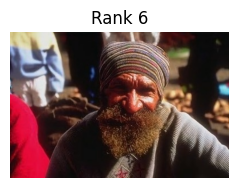

Rank 7:
Distance: 18.194085188878546

For channel R:
Weighted Moments: [84.67674800617715, 84.37685597270554, 0.44395506537151785]

For channel G:
Weighted Moments: [46.35935473435529, 52.99803222250294, 1.3277455980487738]

For channel B:
Weighted Moments: [60.48084507430576, 63.8004171623776, 0.8695511953319662]


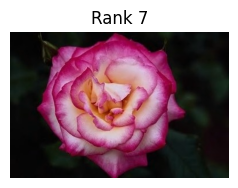

Rank 8:
Distance: 18.44332619214873

For channel R:
Weighted Moments: [90.68605515352101, 69.91371003472983, 0.341728545806913]

For channel G:
Weighted Moments: [47.54720059490228, 52.54152738194868, 1.357135584053418]

For channel B:
Weighted Moments: [54.57299825218797, 53.26031687274177, 1.3311721349846972]


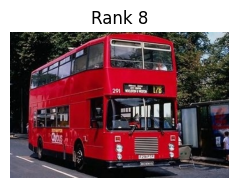

Rank 9:
Distance: 20.153771134320333

For channel R:
Weighted Moments: [82.95629880771594, 69.42403138066338, 0.594946689832097]

For channel G:
Weighted Moments: [59.38818353566512, 63.33323572071747, 1.0114409473553017]

For channel B:
Weighted Moments: [55.968261730185986, 58.56565264571129, 1.2418328115281678]


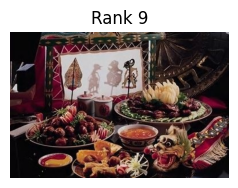

Rank 10:
Distance: 20.69789798426139

For channel R:
Weighted Moments: [92.41844705773747, 66.861905983449, 0.44176462750974166]

For channel G:
Weighted Moments: [64.02958170834609, 61.63573501058364, 1.179492452162954]

For channel B:
Weighted Moments: [52.01150516073449, 53.5423389247181, 1.5952479763392622]


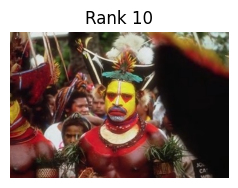

Rank 11:
Distance: 21.123769225858613

For channel R:
Weighted Moments: [100.65258783048466, 78.75119888237491, 0.2543053955494414]

For channel G:
Weighted Moments: [66.01657487669968, 52.028363764340384, 0.7392286911630951]

For channel B:
Weighted Moments: [61.94668587207889, 53.25237402468587, 0.937360394584546]


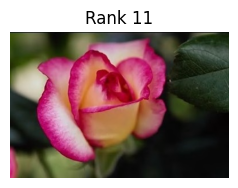

Rank 12:
Distance: 21.494080098795063

For channel R:
Weighted Moments: [77.05882794552326, 85.36429770952819, 0.5135345153839111]

For channel G:
Weighted Moments: [55.01816804545615, 60.65715639480085, 0.5734884202420523]

For channel B:
Weighted Moments: [42.79708124209493, 51.0796974110863, 0.9494846551722207]


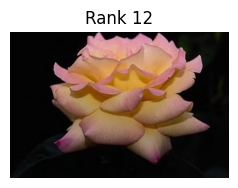

Rank 13:
Distance: 21.852957051643447

For channel R:
Weighted Moments: [85.18252543405833, 74.39633186914837, 0.5043049890836786]

For channel G:
Weighted Moments: [67.85991807791797, 61.25260551095317, 0.942099421578291]

For channel B:
Weighted Moments: [47.22027869679022, 50.95752432446541, 1.5888456699703102]


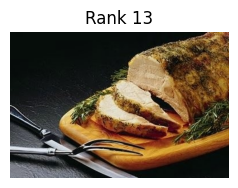

Rank 14:
Distance: 23.429826478820587

For channel R:
Weighted Moments: [107.19728610205493, 67.19818663394202, 0.14514852313004778]

For channel G:
Weighted Moments: [56.211649615113856, 54.89542734601425, 1.160168299456326]

For channel B:
Weighted Moments: [57.04731236816224, 50.71359749007152, 1.3337712636066663]


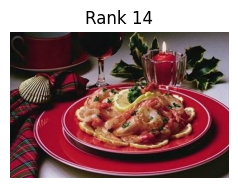

Rank 15:
Distance: 23.790410295304202

For channel R:
Weighted Moments: [76.28036931012164, 87.06216842469007, 0.7308865070777453]

For channel G:
Weighted Moments: [48.867950585117796, 52.112836605718776, 0.8839004223326224]

For channel B:
Weighted Moments: [56.703979519696986, 66.53369841480682, 0.9474841572645993]


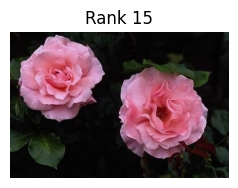

(array([632, 958, 954, 638, 925,  18, 612, 317, 998,  57, 607, 617, 949,
        921, 671], dtype=int64),
 0.010922908782958984)

In [ ]:
def cbir_using_moments(query_image, database_images, top_k, visu=False, moment_weights=[1, 1, 1], func=calculate_color_moments):
    query_features = func(query_image, moment_weights=moment_weights)
    database_features = [func(image, moment_weights=moment_weights) for image in database_images]

    start_time = time.time()
    distances = calculate_similarity(query_features, database_features)
    ranked_indices = np.argsort(distances)
    end_time = time.time()

    elapsed_time = end_time - start_time

    # Display the top 5 results

    if visu:
        plt.figure(figsize=(50, 36))
        plt.subplot(top_k + 1, 1, 1)
        plt.imshow(query_image)
        plt.title('Query Image')
        plt.axis('off')
        print(f"Query Image:\nDistance: {distances[ranked_indices[0]]}")

        if func == calculate_color_moments:
            print(f"\nFor channel R:\nWeighted Moments: {database_features[ranked_indices[0]][0:3]}")
            print(f"\nFor channel G:\nWeighted Moments: {database_features[ranked_indices[0]][3:6]}")
            print(f"\nFor channel B:\nWeighted Moments: {database_features[ranked_indices[0]][6:9]}")
        elif func == calculate_color_moments_with_extended_stats:
            print(f"\nFor channel R:\nWeighted Moments: {database_features[ranked_indices[0]][0:6]}")
            print(f"\nFor channel G:\nWeighted Moments: {database_features[ranked_indices[0]][6:12]}")
            print(f"\nFor channel B:\nWeighted Moments: {database_features[ranked_indices[0]][12:18]}")

        plt.show()

    for i in range(top_k):
        result_image = database_images[ranked_indices[i]]

        if visu:
            plt.figure(figsize=(50, 36))
            plt.subplot(top_k + 1, 1, i + 2)
            plt.imshow(result_image)
            plt.title(f"Rank {i+1}")
            plt.axis('off')

            print(f"Rank {i+1}:\nDistance: {distances[ranked_indices[i]]}")

            if func == calculate_color_moments:
                print(f"\nFor channel R:\nWeighted Moments: {database_features[ranked_indices[i]][0:3]}")
                print(f"\nFor channel G:\nWeighted Moments: {database_features[ranked_indices[i]][3:6]}")
                print(f"\nFor channel B:\nWeighted Moments: {database_features[ranked_indices[i]][6:9]}")
            elif func == calculate_color_moments_with_extended_stats:
                print(f"\nFor channel R:\nWeighted Moments: {database_features[ranked_indices[i]][0:6]}")
                print(f"\nFor channel G:\nWeighted Moments: {database_features[ranked_indices[i]][6:12]}")
                print(f"\nFor channel B:\nWeighted Moments: {database_features[ranked_indices[i]][12:18]}")

            plt.show()

    return ranked_indices[:top_k], elapsed_time


query_image_index = 632
query_image = images[query_image_index]

cbir_using_moments(query_image, images, 15, visu=True)

We retrieved the top 15 images (632, 958, 954, 638, 925,  18, 612, 317, 998,  57, 607, 617, 949, 921, 671) for query image with index 632 when all the three moments have the same weight (1).

6 images are relevent and retrieved.

Also you can observe the length of the feature vector = 3 moments x 3 channels = 9.

Query Image:
Distance: 0.0

For channel R:
Weighted Moments: [95.00933804229135, 83.43261762425914, 0.3702757181452361, 49.0, 6.0, -1.504863045486605]

For channel G:
Weighted Moments: [52.749277843276104, 61.58745633724671, 1.2739375622392948, 26.0, 3.0, 0.26720873365337416]

For channel B:
Weighted Moments: [51.83636485458828, 57.98441507983839, 1.316950951827229, 24.0, 6.0, 0.5180503306932072]


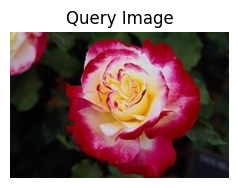

Rank 1:
Distance: 0.0

For channel R:
Weighted Moments: [95.00933804229135, 83.43261762425914, 0.3702757181452361, 49.0, 6.0, -1.504863045486605]

For channel G:
Weighted Moments: [52.749277843276104, 61.58745633724671, 1.2739375622392948, 26.0, 3.0, 0.26720873365337416]

For channel B:
Weighted Moments: [51.83636485458828, 57.98441507983839, 1.316950951827229, 24.0, 6.0, 0.5180503306932072]


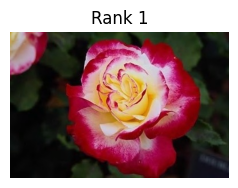

Rank 2:
Distance: 23.978487475448187

For channel R:
Weighted Moments: [89.21729545313792, 86.97301371821777, 0.4244498289466313, 32.0, 7.0, -1.5520835683921126]

For channel G:
Weighted Moments: [60.20586150471445, 55.47114031335778, 0.5500301321422, 35.0, 7.0, -1.1621617517163516]

For channel B:
Weighted Moments: [53.39906830866221, 51.723840809172835, 0.6897948890976038, 25.0, 7.0, -0.9896879007840216]


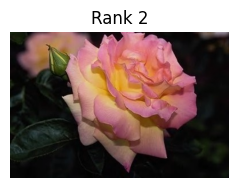

Rank 3:
Distance: 24.65202345147603

For channel R:
Weighted Moments: [82.95629880771594, 69.42403138066338, 0.594946689832097, 61.0, 6.0, -1.0050678961267732]

For channel G:
Weighted Moments: [59.38818353566512, 63.33323572071747, 1.0114409473553017, 30.0, 5.0, -0.270914614624453]

For channel B:
Weighted Moments: [55.968261730185986, 58.56565264571129, 1.2418328115281678, 30.0, 7.0, 0.42641306602734286]


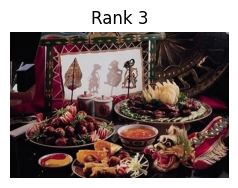

Rank 4:
Distance: 26.598244736936657

For channel R:
Weighted Moments: [82.57424595611519, 82.22466022613895, 0.5863625487800258, 46.0, 3.0, -1.259786835710832]

For channel G:
Weighted Moments: [59.18357329615719, 63.46441184071601, 0.9536054379763399, 28.0, 5.0, -0.44647643278875293]

For channel B:
Weighted Moments: [38.300506643474364, 41.698074661147885, 1.5661231336939936, 19.0, 8.0, 2.003877812933336]


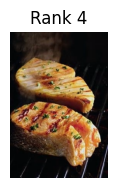

Rank 5:
Distance: 29.0386540652527

For channel R:
Weighted Moments: [93.99833179236157, 82.0240330393152, 0.38804204104568774, 72.0, 4.0, -1.401466101269488]

For channel G:
Weighted Moments: [61.52221679333434, 62.11581803599364, 0.9440273036359408, 31.0, 11.0, -0.2956958413136421]

For channel B:
Weighted Moments: [44.569223995760694, 51.52154220111991, 1.4322940473518573, 21.0, 0.0, 1.4996239637803388]


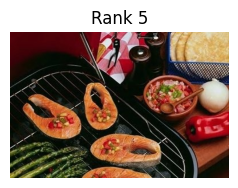

Rank 6:
Distance: 32.05490779170467

For channel R:
Weighted Moments: [77.90549744671443, 83.12126197956792, 0.9094768193095142, 37.0, 8.0, -0.8808872828158147]

For channel G:
Weighted Moments: [48.75313313274364, 42.54304207157696, 0.8951501188779234, 37.0, 6.0, -0.21467663187272157]

For channel B:
Weighted Moments: [54.158538920702085, 55.21307330739248, 1.2037531487384754, 32.0, 6.0, 0.23786746178758822]


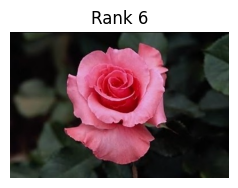

Rank 7:
Distance: 32.85902539842337

For channel R:
Weighted Moments: [75.28813684475608, 73.15257232166196, 0.9093796811559196, 43.0, 15.0, -0.6548782099284289]

For channel G:
Weighted Moments: [56.9511286363501, 65.55348756879575, 1.2871955311645455, 22.999997258186667, 7.999999046325797, 0.32228073326273865]

For channel B:
Weighted Moments: [52.13659677346732, 48.434918184072316, 1.5461195864936517, 39.0, 15.0, 2.0587050204669772]


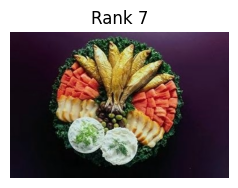

Rank 8:
Distance: 33.49625262869593

For channel R:
Weighted Moments: [84.25832805075008, 74.57477924615297, 0.49413308752679225, 67.99999189376928, 1.9999997615814493, -1.1337791442581744]

For channel G:
Weighted Moments: [58.02256274300271, 61.51696988443376, 1.2256887845543663, 29.0, 8.0, 0.48528868666687375]

For channel B:
Weighted Moments: [35.01791254261858, 50.054360720172724, 2.152300587199267, 12.99999845027942, 2.999999642372174, 4.052785322151766]


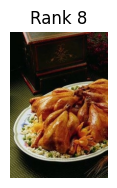

Rank 9:
Distance: 33.801402882561774

For channel R:
Weighted Moments: [84.67674800617715, 84.37685597270554, 0.44395506537151785, 21.0, 7.0, -1.5716404085060884]

For channel G:
Weighted Moments: [46.35935473435529, 52.99803222250294, 1.3277455980487738, 22.0, 5.0, 0.5069657663765539]

For channel B:
Weighted Moments: [60.48084507430576, 63.8004171623776, 0.8695511953319662, 22.0, 5.0, -0.6853441674384748]


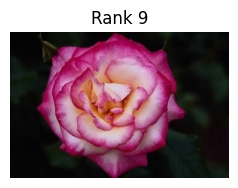

Rank 10:
Distance: 33.89814046069876

For channel R:
Weighted Moments: [80.91901649364445, 73.46927792325383, 0.3719583299192649, 59.0, 5.0, -1.4020107612400077]

For channel G:
Weighted Moments: [50.1363422785289, 56.5857149948531, 1.024618284460935, 21.0, 0.0, -0.2191189837311791]

For channel B:
Weighted Moments: [68.10414252028302, 63.40239838773669, 0.9586937429995801, 41.000002443790585, 16.000000953674373, -0.4824189391610134]


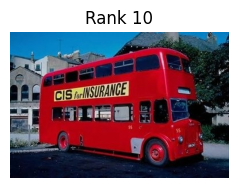

Rank 11:
Distance: 34.0780422190607

For channel R:
Weighted Moments: [94.05338567575927, 72.96975835562316, 0.5640071599717316, 75.0, 10.0, -1.0108403117245262]

For channel G:
Weighted Moments: [62.48737584308401, 63.52874226083469, 1.1351962646593732, 29.0, 12.0, 0.13680846317200013]

For channel B:
Weighted Moments: [59.42139682172274, 60.50516071976789, 1.3400044791857804, 33.0, 11.0, 0.8691985767653807]


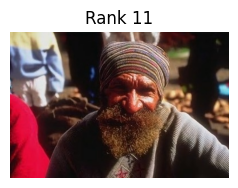

Rank 12:
Distance: 35.99020268684953

For channel R:
Weighted Moments: [87.38309733452843, 75.09982229021797, 0.3369277713008892, 73.0, 6.0, -1.3904781208368233]

For channel G:
Weighted Moments: [54.04911310056832, 51.94991710479036, 0.9083192795538586, 31.0, 10.0, -0.2877139161357585]

For channel B:
Weighted Moments: [41.38480639229056, 40.662524729150235, 1.5533744056143226, 25.0, 9.0, 2.343772747025195]


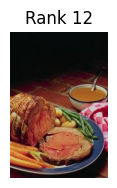

Rank 13:
Distance: 36.166979837793015

For channel R:
Weighted Moments: [67.53977459000453, 74.57708641124539, 1.1695100445750737, 36.0, 5.0, 0.02355823240900401]

For channel G:
Weighted Moments: [57.7205810802443, 69.33318563167282, 1.456006009622592, 27.0, 4.0, 0.835949168063995]

For channel B:
Weighted Moments: [60.68385824650977, 63.23976006301647, 1.3688520695664779, 34.0, 9.0, 0.8526507433746984]


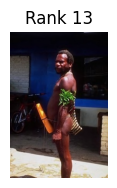

Rank 14:
Distance: 36.88854065981435

For channel R:
Weighted Moments: [85.18252543405833, 74.39633186914837, 0.5043049890836786, 70.0, 6.0, -1.1245594078227674]

For channel G:
Weighted Moments: [67.85991184217131, 61.25260265336775, 0.9420997707863208, 43.999994754791885, 12.99999845027942, -0.25489827878621263]

For channel B:
Weighted Moments: [47.2202801658641, 50.95752510193054, 1.5888455591863122, 24.0, 10.0, 1.8581640057073763]


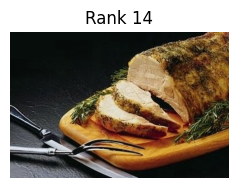

Rank 15:
Distance: 37.647905347509315

For channel R:
Weighted Moments: [75.61002613860182, 75.47675435264298, 0.8391219280012456, 51.0, 0.0, -0.5085927336413278]

For channel G:
Weighted Moments: [65.3747051144328, 73.52593022054936, 1.1104047487648334, 31.0, 3.0, -0.14537615882570698]

For channel B:
Weighted Moments: [69.19459010922219, 68.06102904675053, 0.8709937977484227, 38.0, 9.0, -0.645044889301225]


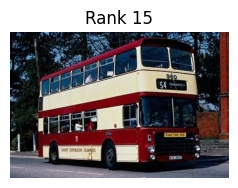

(array([632, 638, 998, 959, 954, 606, 982, 963, 612, 344,  18, 950,  65,
        949, 322], dtype=int64),
 0.008422136306762695)

In [ ]:
query_image_index = 632
query_image = images[query_image_index]

cbir_using_moments(query_image, images, 15, visu=True, moment_weights=[1, 1, 1,1,1,1],func=calculate_color_moments_with_extended_stats)

We retrieved the top 15 images (632, 638, 998, 959, 954, 606, 982, 963, 612, 344,  18, 950,  65, 949, 322) for query image with index 632 when all the three moments have the same weight (1).

4 images are relevent and retrieved.

The ‘task_three’ function evaluates a Content-Based Image Retrieval (CBIR) system using color moments. It takes a query image, a set of database images, and parameters like the number of top results (‘top_k’), relevant index range (‘from_’ to ‘to’), moment weights, and the moment calculation function (‘func’). Internally, it uses ‘cbir_using_moments’ to retrieve top results and the measured elapsed time, then employs ‘evaluation_metrics’ which is used in task 2 to calculate key metrics. The function returns False Positive Rate, True Positive Rate (Recall), Precision, F1 Score, and elapsed time for system evaluation.

In [ ]:
def tp_relevant_retrieved(from_, to, indices):
    r_r = 0
    for idx in indices:
        if from_ <= idx <= to:
            r_r += 1
    return r_r


def evaluation_metrics(from_, to, indices):
    tp = tp_relevant_retrieved(from_, to, indices)
    fp = len(indices) - tp
    fn = 100 - tp
    tn = 1000 - (tp + fp + fn)

    tpr_recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0

    precision = tp / (tp + fp) if (tp + fp) != 0 else 0

    f1_score = (2 * tpr_recall * precision) / (tpr_recall + precision) if (tpr_recall + precision) != 0 else 0

    return tpr_recall, fpr, precision, f1_score


def task_three(query_image, database_images, top_k, from_, to, moment_weights=[1, 1, 1], func=calculate_color_moments):
    top_idx, elapsed_time = cbir_using_moments(query_image, database_images, top_k, moment_weights=moment_weights, func=func)
    tpr_recall, fpr, precesion, f1_score = evaluation_metrics(from_, to, top_idx)

    return fpr, tpr_recall, precesion, f1_score, elapsed_time


def plot_roc_curve_from_values(fpr, tpr):
    auc_value = np.trapz(tpr, fpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_value:.2f}' if auc_value is not None else '')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

The ‘run’ function, employed in task 2, but allowing customization through two parameters. The ‘moment_weights’ parameter specifies the weights for mean, standard deviation, and skewness, initialized with equal values by default. Additionally, the ‘func’ parameter sets the color moment calculation function, with ‘calculate_color_moments’ as the default. This flexibility in parameters allows seamless transition to a subsequent part using an extended moment calculation function.
Also the same function ‘plot_roc_curve_from_values’ that is used in task2 is also used in this task to plot the roc curve.




In [ ]:
def run(moment_weights=[1, 1, 1], func=calculate_color_moments):
    img_lst = [5, 105, 290, 345, 427, 500, 665, 777, 838, 911]
    top_imgs = 0

    fpr_avg = []
    tpr_avg = []
    precesion_avg = []
    f1_avg = []
    et_avg = []

    for n in range(21):
        from_ = 0
        to = 99

        fpr_lst = []
        tpr_lst = []
        precesion_lst = []
        f1_lst = []
        et_lst = []

        for img in img_lst:
            f, t, p, f1, et = task_three(images[img], images, top_imgs, from_, to, moment_weights, func=func)
            fpr_lst.append(f)
            tpr_lst.append(t)
            precesion_lst.append(p)
            f1_lst.append(f1)
            et_lst.append(et)

            from_ += 100
            to += 100

        fpr_avg.append(sum(fpr_lst) / len(fpr_lst))
        tpr_avg.append(sum(tpr_lst) / len(tpr_lst))

        precesion_avg.append(sum(precesion_lst) / len(precesion_lst))
        f1_avg.append(sum(f1_lst) / len(f1_lst))
        et_avg.append(sum(et_lst) / len(et_lst))

        top_imgs += 50

    recall_avg_avg = sum(tpr_avg) / len(tpr_avg)
    precesion_avg_avg = sum(precesion_avg) / len(precesion_avg)
    f1_avg_avg = sum(f1_avg) / len(f1_avg)
    et_avg_avg = sum(et_avg) / len(et_avg)

    print(f"Average recall: {recall_avg_avg}")
    print(f"Average precesion: {precesion_avg_avg}")
    print(f"Average f1 score: {f1_avg_avg}")
    print(f"Average elapsed time: {et_avg_avg}")

    plot_roc_curve_from_values(fpr_avg, tpr_avg)

Average recall: 0.7386190476190476
Average precesion: 0.18731635212625924
Average f1 score: 0.2644875298731115
Average elapsed time: 0.0067355825787498835


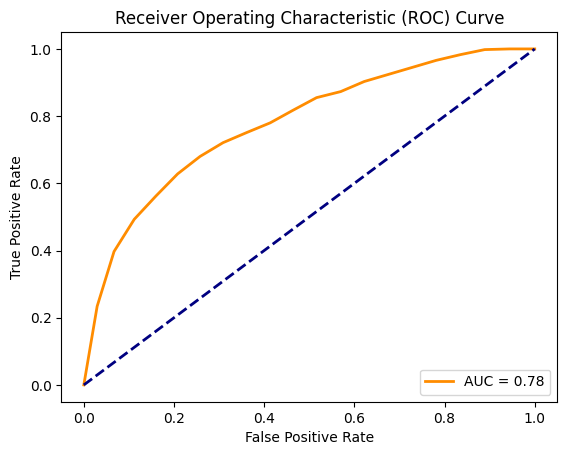

In [ ]:
run()

Average recall: 0.7178571428571429
Average precesion: 0.17948526202899268
Average f1 score: 0.2540589644772971
Average elapsed time: 0.0065716221219017405


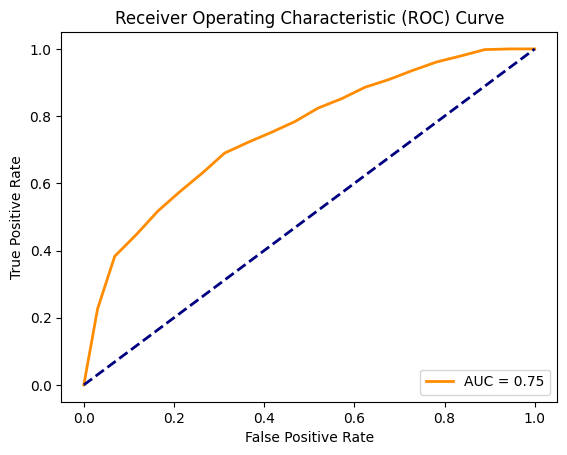

In [ ]:
run(moment_weights=[3, 1, 1])

Average recall: 0.7536666666666667
Average precesion: 0.18986566512672218
Average f1 score: 0.26927679891242473
Average elapsed time: 0.006526131857009162


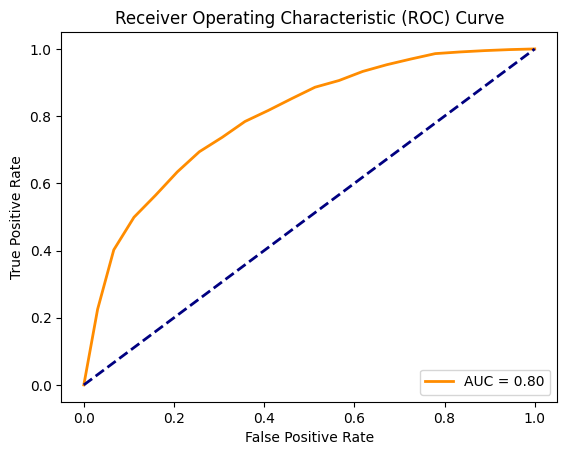

In [ ]:
run(moment_weights=[1, 3, 1])

Average recall: 0.7385714285714284
Average precesion: 0.1873242793841865
Average f1 score: 0.26444499761545315
Average elapsed time: 0.006548121997288293


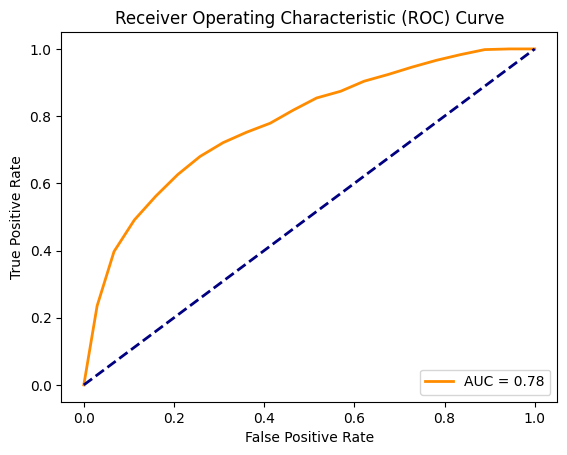

In [ ]:
run(moment_weights=[1, 1, 3])

We can realize that when we give the standard deviation a larger weight than the mean and skewness, it gives us enhanced model which is good.

The AUC when treating all the moments the same is 0.78, after giving the standarad deviation a larger weight while keeping the rest unweighted the AUC becomes 0.80. I think because the used dataset might have a wider range of color variations than average color intensity. In such cases, standard deviation helps capture this diversity, making it a more discriminative feature than the mean.

Giving extra importance to skewness does not affect the model, while giving extra weight for mean makes the model worse (AUC = 0.75). The mean might be too sensitive to outlier pixels or background noise in images. This could lead to inaccurate comparisons and reduce performance when given a higher weight.

The reason of Skewness does not improve the model nor getting it worse is that
our dataset primarily consists of images with relatively symmetrical color distributions (closer to bell curves), skewness might not offer much additional discriminative power compared to standard deviation.
In such cases, standard deviation, which measures the overall spread of colors around the mean, might already be sufficient to distinguish images based on color characteristics. So, skewness value is zero when the color distribution is symmetrical distribution (like a bell curve) that means it does not give any extra information.

Average recall: 0.6965238095238095
Average precesion: 0.17310277100248353
Average f1 score: 0.24475641813916912
Average elapsed time: 0.007342919849214098


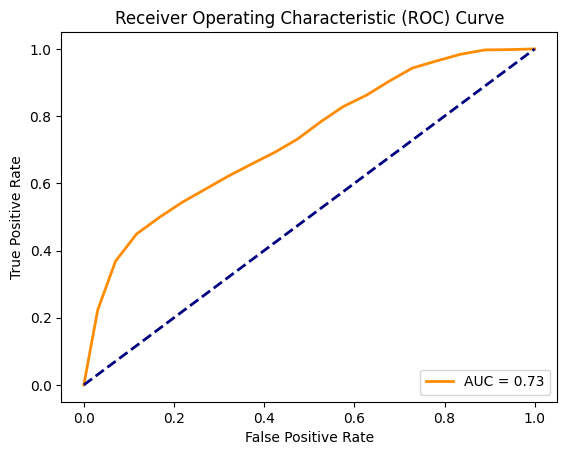

In [ ]:
run(moment_weights=[1, 1, 1, 1, 1, 1], func=calculate_color_moments_with_extended_stats)

Average recall: 0.7073809523809524
Average precesion: 0.17631552831781713
Average f1 score: 0.24953060140671818
Average elapsed time: 0.007395064263116747


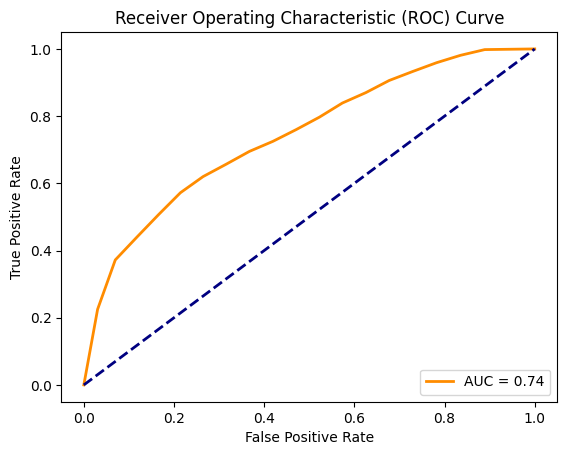

In [ ]:
run(moment_weights=[3, 1, 1, 1, 1, 1], func=calculate_color_moments_with_extended_stats)

Average recall: 0.7152857142857143
Average precesion: 0.17989268961172988
Average f1 score: 0.25378827057997777
Average elapsed time: 0.00750362646012079


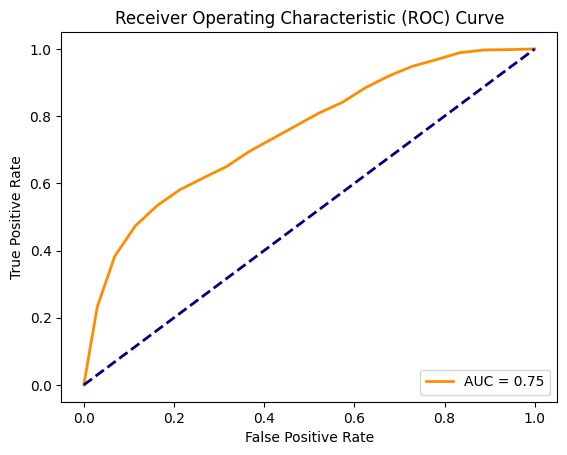

In [ ]:
run(moment_weights=[1, 3, 1, 1, 1, 1], func=calculate_color_moments_with_extended_stats)

Average recall: 0.6965238095238095
Average precesion: 0.17310541650512903
Average f1 score: 0.24476012871430827
Average elapsed time: 0.0076190096991402756


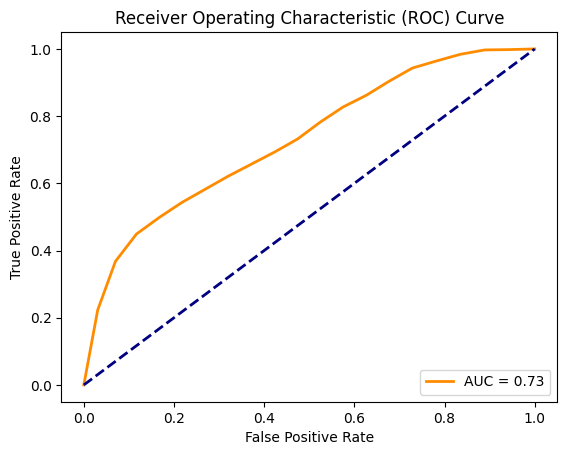

In [ ]:
run(moment_weights=[1, 1, 3, 1, 1, 1], func=calculate_color_moments_with_extended_stats)

Average recall: 0.696857142857143
Average precesion: 0.1738591101716931
Average f1 score: 0.24518091465924274
Average elapsed time: 0.007870392572312127


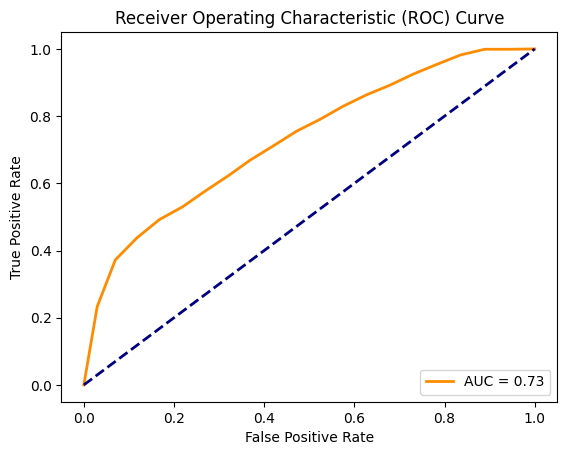

In [ ]:
run(moment_weights=[1, 1, 1, 3, 1, 1], func=calculate_color_moments_with_extended_stats)

Average recall: 0.6760952380952381
Average precesion: 0.166240054352007
Average f1 score: 0.23549377658477616
Average elapsed time: 0.007929817835489909


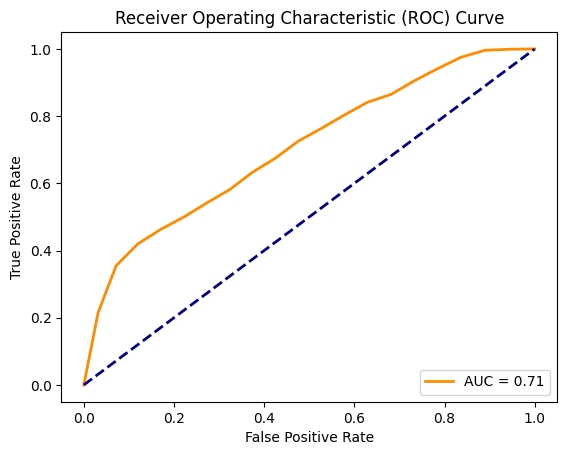

In [ ]:
run(moment_weights=[1, 1, 1, 1, 3, 1], func=calculate_color_moments_with_extended_stats)

Average recall: 0.6967142857142857
Average precesion: 0.17296763048162872
Average f1 score: 0.24469608207000954
Average elapsed time: 0.007937083925519672


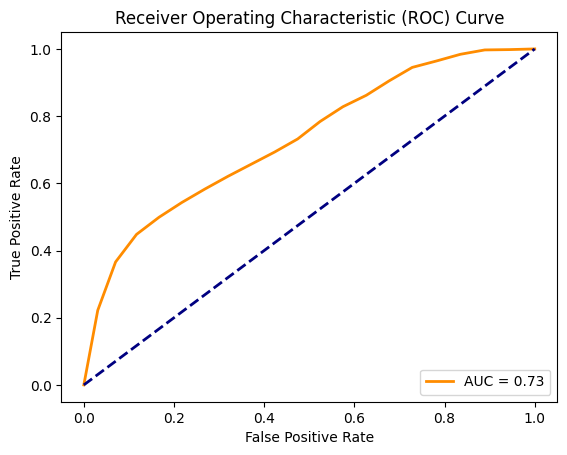

In [ ]:
run(moment_weights=[1, 1, 1, 1, 1, 3], func=calculate_color_moments_with_extended_stats)

We can realize that adding extra moments is not good as we thought!

Weighting individual moments hasn't significantly boosted performance. The highest AUC  achieved with additional moments (0.75) still falls below the best score without them (0.80).

Adding more features without careful consideration can increase model complexity, making it more prone to overfitting the training data and generalizing poorly to unseen images. Besides, the model might start to focus on patterns specific to the training set, including noise or irrelevant variations, leading to suboptimal performance on new images.

The mode as shown has significantly reduced the performance of the model to 0.71, the reason is that it is only captures the most frequent color value in an image, potentially missing valuable information about the overall distribution of colors. By weighting the mode, we're giving more importance to the most frequent color, which might not always be the most discriminative feature for distinguishing relevant images.Also, the mode can be easily skewed by outliers and noise pixels.

The median represents the middle value in the distribution, reflecting the overall "center" of the color range. This provides more comprehensive information about the color characteristics within an image.
Unlike mode, whichcan be easily skewed by outliers and noise pixels, the median is more robust and remains reliable even in noisy images.

Also, adding extra features like kurtosis can increase model complexity and lead to overfitting if not carefully optimized. Because When combining kurtosis with other moments like mean and standard deviation, kurtosis can provide additional context and nuance to the overall color representation, potentially aiding in more accurate similarity comparisons which may lead to overfitting.


Average recall: 0.7542380952380953
Average precesion: 0.19085275896765283
Average f1 score: 0.27039522549951567
Average elapsed time: 0.007043787411281041


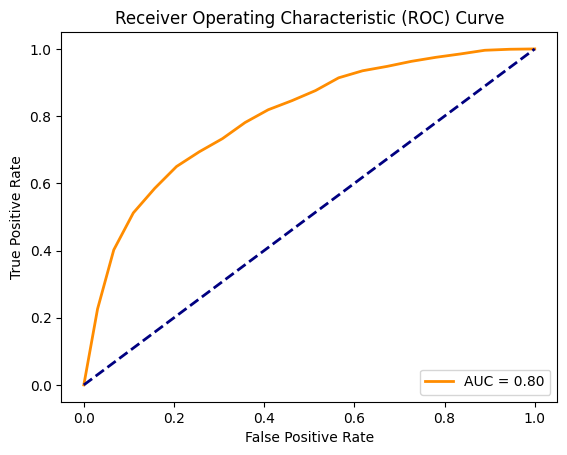

In [ ]:
run(moment_weights=[0.3, 0.6, 0.9])

Average recall: 0.7541428571428572
Average precesion: 0.19077901921534166
Average f1 score: 0.27031215671644687
Average elapsed time: 0.014176867121741885


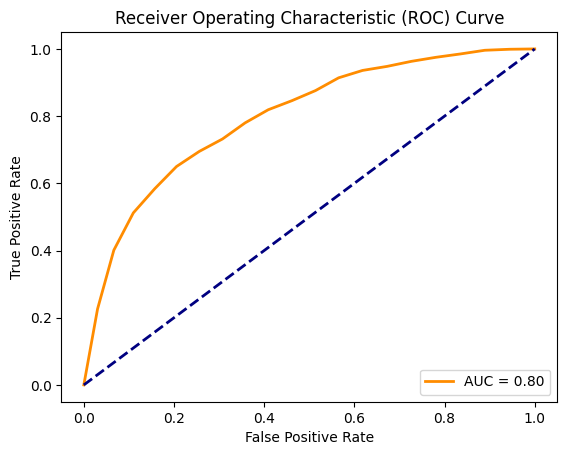

In [ ]:
run(moment_weights=[0.3, 0.6, 0.4])

Average recall: 0.7540952380952382
Average precesion: 0.1907582709160219
Average f1 score: 0.2702828294299768
Average elapsed time: 0.014089595703851609


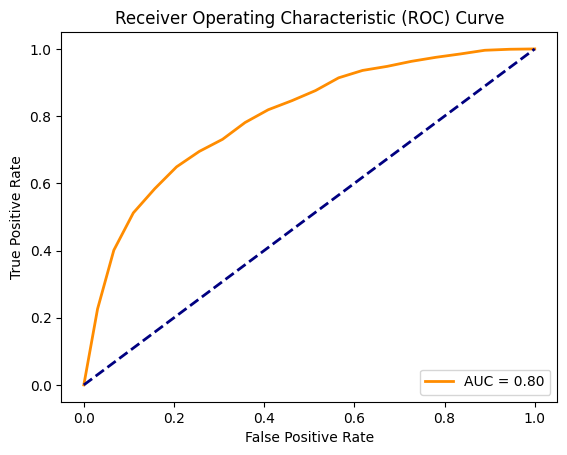

In [ ]:
run(moment_weights=[0.3, 0.6, 0])

Average recall: 0.723190476190476
Average precesion: 0.1816734253207274
Average f1 score: 0.2569401560059676
Average elapsed time: 0.013576170376368931


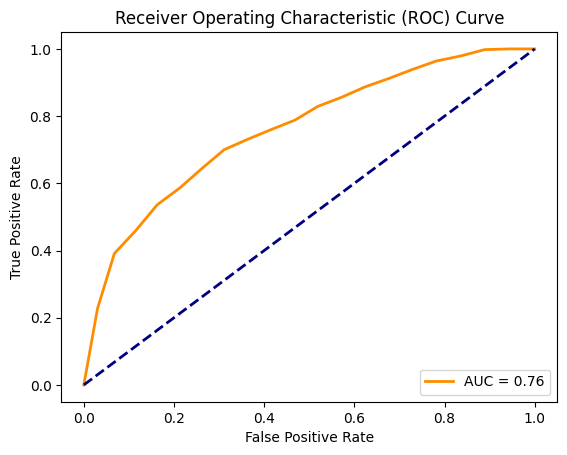

In [ ]:
run(moment_weights=[0.6, 0.3, 0])

Here is evidence that the skewness value is zero because, despite its weight, the model's AUC predominantly considers the weights of mean and standard deviation (I am discussing this without extra moments). This observation supports the idea that the dataset primarily comprises images with relatively symmetrical color distributions, resembling bell curves. Consequently, skewness may not provide significant additional discriminative power compared to standard deviation.